## Predict

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mmocr.apis import TextRecInferencer, TextDetInferencer, MMOCRInferencer
import os
import sys
import cv2
from time import sleep
import time
import gc

# def image_rotate(image, position, angle):
#     # 获取旋转矩阵
#     rotation_matrix = cv2.getRotationMatrix2D(position, angle, 1)
#     # 旋转文本
#     # rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
#     # rotated_image = cv2.transpose(image)
#     rotated_image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)

#     # 重新计算旋转后的文本位置
#     rotated_position = np.dot(rotation_matrix[:, :2], np.array(position)) + rotation_matrix[:, 2]

#     h, w = rotated_image.shape[:2]
#     image = rotated_image[int(rotated_position[1] - h/2):int(rotated_position[1] + h/2), int(rotated_position[0] - w/2):int(rotated_position[0] + w/2)]
#     return image
def image_rotate(image, position, angle):
    # 获取旋转矩阵
    rotation_matrix = cv2.getRotationMatrix2D(position, angle, 1)
    
    # 旋转文本并填充缺失的像素
    rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

    # 重新计算旋转后的文本位置
    rotated_position = np.dot(rotation_matrix[:, :2], np.array(position)) + rotation_matrix[:, 2]

    return rotated_image



def draw_text_based_on_direction(image, points, text, font_scale=1, font_thickness=1, font_color=(255, 255, 255)):
    # 将点坐标转换为OpenCV的形状
    points = np.array(points, np.int32).reshape((-1, 1, 2))

    # 计算Polyline的X和Y方向的长度
    x_length = np.abs(points[:, 0, 0].max() - points[:, 0, 0].min())
    y_length = np.abs(points[:, 0, 1].max() - points[:, 0, 1].min())

    # 设置文本的位置和方向
    # position = (points[:, 0, 0].mean(), points[:, 0, 1].mean())
    direction = 'horizontal' if x_length >= y_length else 'vertical'

    # 根据方向设置文本的角度
    angle = 0 if direction == 'horizontal' else 90

    # 绘制Polyline
    cv2.drawContours(image, [points], -1, (0, 255, 0), 3)

    # 在图像上绘制旋转后的文本
    if angle != 0:

        # 获取旋转矩阵
        # rotation_matrix = cv2.getRotationMatrix2D(position, angle, 1)
        # 旋转文本
        # 进行90度逆时针翻转
        # rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
        # rotated_image = cv2.transpose(image)
        rotated_image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)

        # 重新计算旋转后的文本位置
        # rotated_position = np.dot(rotation_matrix[:, :2], np.array(position)) + rotation_matrix[:, 2]

        # h, w = rotated_image.shape[:2]
        # plt.imshow(rotated_image)
        # plt.show()
        # print(h, w)
        image = rotated_image
        # image = rotated_image[int(rotated_position[1] - h/2):int(rotated_position[1] + h/2), int(rotated_position[0] - w/2):int(rotated_position[0] + w/2)]
        print(points.shape, type(points))
        rotated_points = np.array([[point[0][1], (image.shape[0] - point[0][0])] for point in points] , np.int32).reshape((-1,1,2))
        print(rotated_points.shape)
        center_x = image.shape[1] // 2
        center_y = image.shape[0] // 2

        distances = np.linalg.norm(rotated_points - [center_x, center_y], axis=2)
        closet_point_index = np.argmin(distances)

        position = tuple(rotated_points[closet_point_index][0])
        
    else:
        center_x = image.shape[1] // 2
        center_y = image.shape[0] // 2

        distances = np.linalg.norm(points - [center_x, center_y], axis=2)
        closet_point_index = np.argmin(distances)

        position = tuple(points[closet_point_index][0])
        # rotated_position = position

    # 在图像上绘制文本
    cv2.putText(image, text, position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_color, font_thickness, cv2.LINE_AA)

    # 反向旋转整个图像
    if angle != 0:
        # image = image_rotate(image, position, angle)
        # image = image_rotate(image, position, angle)
        # image = image_rotate(image, position, angle)
        image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
        image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
        image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
        # image = cv2.transpose(image)
        # image = cv2.transpose(image)
        # image = cv2.transpose(image)
        # reverse_rotation_matrix = cv2.getRotationMatrix2D(rotated_position, -angle, 1)
        # image = cv2.warpAffine(image, reverse_rotation_matrix, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)

    return image

# path = "./data/icdar2015/imgs/training"
path = "./data/imgs/CLAHE" # equalization histogram image
imgs = [file for file in os.listdir(path) if file.find(".jpg") != -1]
for filename in imgs:
    imgpath = os.path.join(path, filename)
    img = cv2.imread(os.path.join("./data/imgs", filename), cv2.IMREAD_COLOR) #imgpath
    # checkpoint = "./data/icdar/epoch_60.pth"
    # cfg_file = "./data/icdar/dbnet_resnet50-dcnv2_fpnc_1200e_icdar2015.py"
    det_checkpoint = os.path.join(os.getcwd(), "by慶偉/model/epoch_60.pth")
    det_file = os.path.join(os.getcwd(), "by慶偉/model/dbnetpp_resnet50-dcnv2_fpnc_1200e_icdar2015_plusctw1500.py")
    
    rec_checkpoint = "abinet_union14m-cbf19742.pth"
    # rec_checkpoint = "abinet_pretrain-45deac15.pth"
    rec_file = os.path.join(os.getcwd(), "mmocr/configs/textrecog/abinet/abinet-vision_10e_union14m.py")
    # rec_file = os.path.join(os.getcwd(), "mmocr/configs/textrecog/abinet/abinet_20e_st-an_mj.py")
    model = MMOCRInferencer(det=det_file, det_weights=det_checkpoint, 
                            rec=rec_file, rec_weights=rec_checkpoint) 

    # infer = TextDetInferencer(cfg_file, checkpoint)



    result = model(imgpath, return_vis=True)

    texts = result['predictions'][0]['rec_texts']
    polygons = result['predictions'][0]['det_polygons']
    scores = result['predictions'][0]['rec_scores']
    for idx, polygon in enumerate(polygons):
        text = texts[idx]
        
        cnt1 = [int(value) for value in polygon]
        cnt1 = np.array([cnt1[i:i+2] for i in range(0, len(cnt1), 2)])
        area = cv2.contourArea(cnt1)

        if (area > 10000 and len(text) > 2): #(scores[idx] > 0.5):
        
            # cv2.drawContours(img, [cnt1], -1, (0, 255, 0), 3)
            
            # Retrieve bounding box of cnt1
            # x, y, w, h = cv2.boundingRect(cnt1)
            # replace any '<UKN>'  as ''
            text = text.replace('<UKN>', '').upper()
            # puttext the text on x,y
            img = draw_text_based_on_direction(img, cnt1, text, font_scale=5, font_thickness=10, font_color=(0, 255, 0))

            # cv2.putText(img, text, (x-100, y), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 255, 0), 10, cv2.LINE_AA)

        print(f"result : {texts}")
        gc.collect()
    if (filename.find("img") == -1):
        cv2.imwrite(f"C:/Users/User/Desktop/C_VSCode/mmocr/data/imgs/dst/{filename}", img)

        # print(result['predictions'][0])
        
        # plt.figure(figsize=(5, 10))
        # plt.imshow(img) #result['visualization'][0]
        # plt.title(filename)
        # plt.show()
    
    gc.collect()
    # sys.exit()

Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth


c:\Users\User\anaconda3\envs\mmocr\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


03/13 17:36:19 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:36:19 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:36:19 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:36:19 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:36:19 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:36:19 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:36:19 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:36:19 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03/13 17:36:19 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.4.conv2 is upgraded to version 2.
03/13 17:36:19 - mm

c:\Users\User\anaconda3\envs\mmocr\lib\site-packages\mmengine\visualization\visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '
c:\Users\User\anaconda3\envs\mmocr\lib\site-packages\mmengine\visualization\visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.WandbVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


c:\Users\User\anaconda3\envs\mmocr\lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

result : ['.C', '.', 'of', 'TAME', '-', '1', '-', '1EPAAAAA']
result : ['.C', '.', 'of', 'TAME', '-', '1', '-', '1EPAAAAA']
result : ['.C', '.', 'of', 'TAME', '-', '1', '-', '1EPAAAAA']
result : ['.C', '.', 'of', 'TAME', '-', '1', '-', '1EPAAAAA']
result : ['.C', '.', 'of', 'TAME', '-', '1', '-', '1EPAAAAA']
result : ['.C', '.', 'of', 'TAME', '-', '1', '-', '1EPAAAAA']
result : ['.C', '.', 'of', 'TAME', '-', '1', '-', '1EPAAAAA']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['.C', '.', 'of', 'TAME', '-', '1', '-', '1EPAAAAA']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:36:25 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:36:25 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:36:25 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:36:25 - mmengine -

c:\Users\User\anaconda3\envs\mmocr\lib\site-packages\mmengine\visualization\visualizer.py:831: UserWarning: 
Warning: The polygon is out of bounds, the drawn polygon may not be in the image
  warnings.warn(

result : ['4', 'S', 'X', 'EEX', '5', 'AA', 'O', 'O', 'SOILO', '.4408', 'PN', 'C', '64', 'DDJ', 'VN']
result : ['4', 'S', 'X', 'EEX', '5', 'AA', 'O', 'O', 'SOILO', '.4408', 'PN', 'C', '64', 'DDJ', 'VN']
result : ['4', 'S', 'X', 'EEX', '5', 'AA', 'O', 'O', 'SOILO', '.4408', 'PN', 'C', '64', 'DDJ', 'VN']
result : ['4', 'S', 'X', 'EEX', '5', 'AA', 'O', 'O', 'SOILO', '.4408', 'PN', 'C', '64', 'DDJ', 'VN']
result : ['4', 'S', 'X', 'EEX', '5', 'AA', 'O', 'O', 'SOILO', '.4408', 'PN', 'C', '64', 'DDJ', 'VN']
result : ['4', 'S', 'X', 'EEX', '5', 'AA', 'O', 'O', 'SOILO', '.4408', 'PN', 'C', '64', 'DDJ', 'VN']
result : ['4', 'S', 'X', 'EEX', '5', 'AA', 'O', 'O', 'SOILO', '.4408', 'PN', 'C', '64', 'DDJ', 'VN']
result : ['4', 'S', 'X', 'EEX', '5', 'AA', 'O', 'O', 'SOILO', '.4408', 'PN', 'C', '64', 'DDJ', 'VN']
result : ['4', 'S', 'X', 'EEX', '5', 'AA', 'O', 'O', 'SOILO', '.4408', 'PN', 'C', '64', 'DDJ', 'VN']
result : ['4', 'S', 'X', 'EEX', '5', 'AA', 'O', 'O', 'SOILO', '.4408', 'PN', 'C', '64', 'DD

result : ['1', 'O', 'O', 'C606']
result : ['1', 'O', 'O', 'C606']
result : ['1', 'O', 'O', 'C606']
result : ['1', 'O', 'O', 'C606']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:36:33 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:36:33 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:36:33 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:36:33 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:36:33 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:36:33 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:36:33 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.

(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['SOSSIBA', '1000--550', '3C402F']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['SOSSIBA', '1000--550', '3C402F']
result : ['SOSSIBA', '1000--550', '3C402F']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:36:35 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:36:35 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:36:35 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:36:35 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:36:35 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:36:35 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:36:35 - mme

result : ['Cc005-79']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:36:36 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:36:36 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:36:36 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:36:36 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:36:36 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:36:36 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:36:36 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:36:36 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.


result : ['IN3161']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:36:38 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:36:38 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:36:38 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:36:38 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:36:38 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:36:38 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:36:38 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:36:38 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03

result : ['PN.54', '14408', '50110s']
result : ['PN.54', '14408', '50110s']
result : ['PN.54', '14408', '50110s']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:36:39 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:36:39 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:36:39 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:36:39 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:36:39 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:36:39 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:36:39 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:36:39 - 

(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['DIV', 'PI', '1', '-', 'M', 'MARD', '69', '32', 'E']
result : ['DIV', 'PI', '1', '-', 'M', 'MARD', '69', '32', 'E']
result : ['DIV', 'PI', '1', '-', 'M', 'MARD', '69', '32', 'E']
result : ['DIV', 'PI', '1', '-', 'M', 'MARD', '69', '32', 'E']
result : ['DIV', 'PI', '1', '-', 'M', 'MARD', '69', '32', 'E']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['DIV', 'PI', '1', '-', 'M', 'MARD', '69', '32', 'E']
result : ['DIV', 'PI', '1', '-', 'M', 'MARD', '69', '32', 'E']
result : ['DIV', 'PI', '1', '-', 'M', 'MARD', '69', '32', 'E']
result : ['DIV', 'PI', '1', '-', 'M', 'MARD', '69', '32', 'E']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:36:42 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:36:42 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:36:42 - mmen

result : ['(A623']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:36:43 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:36:43 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:36:43 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:36:43 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:36:43 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:36:43 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:36:43 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:36:43 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03/

result : ['NLLE-', '-', 'tec']
result : ['NLLE-', '-', 'tec']
result : ['NLLE-', '-', 'tec']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:36:45 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:36:45 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:36:45 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:36:45 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:36:45 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:36:45 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:36:45 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:36:45 - mmengine - INFO - Mod

result : ['/F128A']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:36:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:36:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:36:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:36:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:36:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:36:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:36:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:36:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03

result : ['(C746L=']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:36:47 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:36:47 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:36:47 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:36:47 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:36:47 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:36:47 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:36:47 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:36:47 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
0

result : ['MiN', 'V586', '1', 'C', '1']
result : ['MiN', 'V586', '1', 'C', '1']
result : ['MiN', 'V586', '1', 'C', '1']
result : ['MiN', 'V586', '1', 'C', '1']
result : ['MiN', 'V586', '1', 'C', '1']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:36:49 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:36:49 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:36:49 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:36:49 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:36:49 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:36:49 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:36:49 - mmengine - INFO - Modul

result : ['O', 'O', 'FO00', 'ViTTE']
result : ['O', 'O', 'FO00', 'ViTTE']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['O', 'O', 'FO00', 'ViTTE']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['O', 'O', 'FO00', 'ViTTE']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:36:53 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:36:53 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:36:53 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:36:53 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:36:53 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:36:53 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/1

result : ['V526']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:36:55 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:36:55 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:36:55 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:36:55 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:36:55 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:36:55 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:36:55 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:36:55 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03/1

result : ['(N619G)']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:36:56 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:36:56 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:36:56 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:36:56 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:36:56 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:36:56 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:36:56 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:36:56 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
0

result : ['63', 'C990', 'COREEE']
result : ['63', 'C990', 'COREEE']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['63', 'C990', 'COREEE']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:36:58 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:36:58 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:36:58 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:36:58 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:36:58 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:36:58 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:36:58 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded

result : ['C85']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:36:59 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:36:59 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:36:59 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:36:59 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:36:59 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:36:59 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:36:59 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:36:59 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03/13

result : ['N2410L']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:37:01 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:37:01 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:37:01 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:37:01 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:37:01 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:37:01 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:37:01 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:37:01 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03

result : ['/', 'R', 'V']
result : ['/', 'R', 'V']
result : ['/', 'R', 'V']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:37:02 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:37:02 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:37:02 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:37:02 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:37:02 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:37:02 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:37:02 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:37:02 - mmengine - INFO - ModulatedDeformConvPa

result : ['ANL']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:37:04 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:37:04 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:37:04 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:37:04 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:37:04 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:37:04 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:37:04 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:37:04 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03/13

result : ['181']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:37:06 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:37:06 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:37:06 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:37:06 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:37:06 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:37:06 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:37:06 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:37:06 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03/13

result : ['L', 'NKK']
result : ['L', 'NKK']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:37:07 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:37:07 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:37:07 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:37:07 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:37:07 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:37:07 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:37:07 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:37:07 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is u

result : ['(c005-70']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:37:09 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:37:09 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:37:09 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:37:09 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:37:09 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:37:09 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:37:09 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:37:09 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.


result : [')', 'O', 'I', '1', '1', 'Y12', 'miaaltss', '1', 'STRRE']
result : [')', 'O', 'I', '1', '1', 'Y12', 'miaaltss', '1', 'STRRE']
result : [')', 'O', 'I', '1', '1', 'Y12', 'miaaltss', '1', 'STRRE']
result : [')', 'O', 'I', '1', '1', 'Y12', 'miaaltss', '1', 'STRRE']
result : [')', 'O', 'I', '1', '1', 'Y12', 'miaaltss', '1', 'STRRE']
result : [')', 'O', 'I', '1', '1', 'Y12', 'miaaltss', '1', 'STRRE']
result : [')', 'O', 'I', '1', '1', 'Y12', 'miaaltss', '1', 'STRRE']
result : [')', 'O', 'I', '1', '1', 'Y12', 'miaaltss', '1', 'STRRE']
result : [')', 'O', 'I', '1', '1', 'Y12', 'miaaltss', '1', 'STRRE']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:37:13 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:37:13 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:37:13 - mmengine - INFO - ModulatedDeformConvPack backb

result : ['C606']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:37:14 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:37:14 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:37:14 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:37:14 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:37:14 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:37:14 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:37:14 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:37:14 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03/1

result : ['N8196']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:37:16 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:37:16 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:37:16 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:37:16 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:37:16 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:37:16 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:37:16 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:37:16 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03/

result : ['NKLE', '1', '1', '1', '-', '-', 'T', '1', '1', '1', 'T']
result : ['NKLE', '1', '1', '1', '-', '-', 'T', '1', '1', '1', 'T']
result : ['NKLE', '1', '1', '1', '-', '-', 'T', '1', '1', '1', 'T']
result : ['NKLE', '1', '1', '1', '-', '-', 'T', '1', '1', '1', 'T']
result : ['NKLE', '1', '1', '1', '-', '-', 'T', '1', '1', '1', 'T']
result : ['NKLE', '1', '1', '1', '-', '-', 'T', '1', '1', '1', 'T']
result : ['NKLE', '1', '1', '1', '-', '-', 'T', '1', '1', '1', 'T']
result : ['NKLE', '1', '1', '1', '-', '-', 'T', '1', '1', '1', 'T']
result : ['NKLE', '1', '1', '1', '-', '-', 'T', '1', '1', '1', 'T']
result : ['NKLE', '1', '1', '1', '-', '-', 'T', '1', '1', '1', 'T']
result : ['NKLE', '1', '1', '1', '-', '-', 'T', '1', '1', '1', 'T']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:37:18 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:37:18 - mmengine - INFO - Mo

result : ['NNI L', 'CONNSGO']
result : ['NNI L', 'CONNSGO']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:37:20 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:37:20 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:37:20 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:37:20 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:37:20 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:37:20 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:37:20 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:37:20 - mmengine - INFO - ModulatedDeformConvPack backbone.lay

result : ['NLEI']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:37:21 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:37:21 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:37:21 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:37:21 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:37:21 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:37:21 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:37:21 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:37:21 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03/1

result : ['/N24221', 'WORRO']
result : ['/N24221', 'WORRO']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:37:23 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:37:23 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:37:23 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:37:23 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:37:23 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:37:23 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:37:23 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:37:23 - mmengine - INFO - ModulatedDeformConvPack backbone.lay

result : ['N2410L']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:37:24 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:37:24 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:37:24 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:37:24 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:37:24 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:37:24 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:37:24 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:37:24 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03

result : ['N24221']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:37:26 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:37:26 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:37:26 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:37:26 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:37:26 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:37:26 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:37:26 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:37:26 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03

result : [')', '2259L']
result : [')', '2259L']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:37:28 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:37:28 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:37:28 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:37:28 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:37:28 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:37:28 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:37:28 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:37:28 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 

result : ['A', '122', '<UKN>', 'CFFMM', '1000', 'BEEE', '20tr']
result : ['A', '122', '<UKN>', 'CFFMM', '1000', 'BEEE', '20tr']
result : ['A', '122', '<UKN>', 'CFFMM', '1000', 'BEEE', '20tr']
result : ['A', '122', '<UKN>', 'CFFMM', '1000', 'BEEE', '20tr']
result : ['A', '122', '<UKN>', 'CFFMM', '1000', 'BEEE', '20tr']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['A', '122', '<UKN>', 'CFFMM', '1000', 'BEEE', '20tr']
result : ['A', '122', '<UKN>', 'CFFMM', '1000', 'BEEE', '20tr']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:37:30 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:37:30 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:37:30 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:37:30 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.

result : ['0', 'O', '1', 'IGOOD', '3']
result : ['0', 'O', '1', 'IGOOD', '3']
result : ['0', 'O', '1', 'IGOOD', '3']
result : ['0', 'O', '1', 'IGOOD', '3']
result : ['0', 'O', '1', 'IGOOD', '3']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:37:34 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:37:34 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:37:34 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:37:34 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:37:34 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:37:34 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:37:34 - mmengine - INFO - ModulatedD

result : ['C606']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:37:36 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:37:36 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:37:36 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:37:36 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:37:36 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:37:36 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:37:36 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:37:36 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03/1

result : ['N61961']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:37:37 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:37:37 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:37:37 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:37:37 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:37:37 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:37:37 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:37:37 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:37:37 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03

result : ['(C85))', 'WIll']
result : ['(C85))', 'WIll']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:37:39 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:37:39 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:37:39 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:37:39 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:37:39 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:37:39 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:37:39 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:37:39 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.

result : ['1', '1ROO', 'WII']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['1', '1ROO', 'WII']
result : ['1', '1ROO', 'WII']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:37:41 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:37:41 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:37:41 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:37:41 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:37:41 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:37:41 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:37:41 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 

result : ['(982)', 'fa']
result : ['(982)', 'fa']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:37:42 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:37:42 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:37:42 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:37:42 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:37:42 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:37:42 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:37:42 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:37:42 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv

result : ['S', 'NEEEN', 'will']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['S', 'NEEEN', 'will']
result : ['S', 'NEEEN', 'will']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:37:44 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:37:44 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:37:44 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:37:44 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:37:44 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:37:44 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:37:44 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to ve

result : ['c85)', 'B1']
result : ['c85)', 'B1']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:37:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:37:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:37:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:37:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:37:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:37:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:37:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:37:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 

result : ['10K-15A', 'SCSIGA', 'BAACE', '1', '1', 'SAAAAN', 'WIIl']
result : ['10K-15A', 'SCSIGA', 'BAACE', '1', '1', 'SAAAAN', 'WIIl']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['10K-15A', 'SCSIGA', 'BAACE', '1', '1', 'SAAAAN', 'WIIl']
result : ['10K-15A', 'SCSIGA', 'BAACE', '1', '1', 'SAAAAN', 'WIIl']
result : ['10K-15A', 'SCSIGA', 'BAACE', '1', '1', 'SAAAAN', 'WIIl']
result : ['10K-15A', 'SCSIGA', 'BAACE', '1', '1', 'SAAAAN', 'WIIl']
result : ['10K-15A', 'SCSIGA', 'BAACE', '1', '1', 'SAAAAN', 'WIIl']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:37:48 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:37:48 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:37:48 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:37:48 - mmengine - INFO - ModulatedDef

(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['COSSAA', 'AOONEEEE', '3C402F']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['COSSAA', 'AOONEEEE', '3C402F']
result : ['COSSAA', 'AOONEEEE', '3C402F']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:37:50 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:37:50 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:37:50 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:37:50 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:37:50 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:37:50 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:37:50 - mmengine 

result : ['ONNA', 'N9916', 'WIll']
result : ['ONNA', 'N9916', 'WIll']
result : ['ONNA', 'N9916', 'WIll']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:37:52 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:37:52 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:37:52 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:37:52 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:37:52 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:37:52 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:37:52 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:37:52 - mmengine 

result : ['.', 'O', '191EN', '/', 'IN', 'Y', 'PUNN']
result : ['.', 'O', '191EN', '/', 'IN', 'Y', 'PUNN']
result : ['.', 'O', '191EN', '/', 'IN', 'Y', 'PUNN']
result : ['.', 'O', '191EN', '/', 'IN', 'Y', 'PUNN']
result : ['.', 'O', '191EN', '/', 'IN', 'Y', 'PUNN']
result : ['.', 'O', '191EN', '/', 'IN', 'Y', 'PUNN']
result : ['.', 'O', '191EN', '/', 'IN', 'Y', 'PUNN']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:37:56 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:37:56 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:37:56 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:37:56 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:37:56 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is u

result : ['79:443']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:37:58 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:37:58 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:37:58 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:37:58 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:37:58 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:37:58 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:37:58 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:37:58 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03

result : ['SON', '(8748L)']
result : ['SON', '(8748L)']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:37:59 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:37:59 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:37:59 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:37:59 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:37:59 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:37:59 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:37:59 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:37:59 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.

result : ['V536']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:38:01 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:38:01 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:38:01 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:38:01 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:38:01 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:38:01 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:38:01 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:38:01 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03/1

result : ['(FG23']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:38:03 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:38:03 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:38:03 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:38:03 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:38:03 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:38:03 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:38:03 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:38:03 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03/

result : ['/F128A']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:38:04 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:38:04 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:38:04 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:38:04 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:38:04 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:38:04 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:38:04 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:38:04 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03

result : ['Y536']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:38:06 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:38:06 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:38:06 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:38:06 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:38:06 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:38:06 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:38:06 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:38:06 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03/1

result : ['1', '1136']
result : ['1', '1136']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:38:08 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:38:08 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:38:08 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:38:08 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:38:08 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:38:08 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:38:08 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:38:08 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is

result : ['eM', 'Y536']
result : ['eM', 'Y536']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:38:09 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:38:09 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:38:09 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:38:09 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:38:09 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:38:09 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:38:09 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:38:09 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 

result : ['6', '7', 'R']
result : ['6', '7', 'R']
result : ['6', '7', 'R']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:38:11 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:38:11 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:38:11 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:38:11 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:38:11 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:38:11 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:38:11 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:38:11 - mmengine - INFO - ModulatedDeformConvPa

result : ['C85']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:38:13 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:38:13 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:38:13 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:38:13 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:38:13 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:38:13 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:38:13 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:38:13 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03/13

result : ['.C', 'O', '/', '-', 'a', '17RE']
result : ['.C', 'O', '/', '-', 'a', '17RE']
result : ['.C', 'O', '/', '-', 'a', '17RE']
result : ['.C', 'O', '/', '-', 'a', '17RE']
result : ['.C', 'O', '/', '-', 'a', '17RE']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['.C', 'O', '/', '-', 'a', '17RE']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:38:17 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:38:17 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:38:17 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:38:17 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:38:17 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:38:17 - mmengine - INFO - Modula

result : ['R', '.C', 'O', '-', '1', 'S']
result : ['R', '.C', 'O', '-', '1', 'S']
result : ['R', '.C', 'O', '-', '1', 'S']
result : ['R', '.C', 'O', '-', '1', 'S']
result : ['R', '.C', 'O', '-', '1', 'S']
result : ['R', '.C', 'O', '-', '1', 'S']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:38:21 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:38:21 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:38:21 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:38:21 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:38:21 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:38:21 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to versi

result : ['1', '7', 'M', 'O', 'O', '20D0', 'GG']
result : ['1', '7', 'M', 'O', 'O', '20D0', 'GG']
result : ['1', '7', 'M', 'O', 'O', '20D0', 'GG']
result : ['1', '7', 'M', 'O', 'O', '20D0', 'GG']
result : ['1', '7', 'M', 'O', 'O', '20D0', 'GG']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['1', '7', 'M', 'O', 'O', '20D0', 'GG']
result : ['1', '7', 'M', 'O', 'O', '20D0', 'GG']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:38:26 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:38:26 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:38:26 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:38:26 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:38:26 - mmengine - INFO - ModulatedDeformConvPack backbone.lay

result : ['O', 'O', 'CO', 'OINO', 'OO', 'DEEEEE']
result : ['O', 'O', 'CO', 'OINO', 'OO', 'DEEEEE']
result : ['O', 'O', 'CO', 'OINO', 'OO', 'DEEEEE']
result : ['O', 'O', 'CO', 'OINO', 'OO', 'DEEEEE']
result : ['O', 'O', 'CO', 'OINO', 'OO', 'DEEEEE']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['O', 'O', 'CO', 'OINO', 'OO', 'DEEEEE']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:38:31 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:38:31 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:38:31 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:38:31 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:38:31 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13

result : ['(8148L))1']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:38:33 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:38:33 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:38:33 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:38:33 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:38:33 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:38:33 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:38:33 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:38:33 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.

result : ['A', '2', 'OF', '3D', 'CO', 'O', 'O', 'woteeeaaa', 'SRSS']
result : ['A', '2', 'OF', '3D', 'CO', 'O', 'O', 'woteeeaaa', 'SRSS']
result : ['A', '2', 'OF', '3D', 'CO', 'O', 'O', 'woteeeaaa', 'SRSS']
result : ['A', '2', 'OF', '3D', 'CO', 'O', 'O', 'woteeeaaa', 'SRSS']
result : ['A', '2', 'OF', '3D', 'CO', 'O', 'O', 'woteeeaaa', 'SRSS']
result : ['A', '2', 'OF', '3D', 'CO', 'O', 'O', 'woteeeaaa', 'SRSS']
result : ['A', '2', 'OF', '3D', 'CO', 'O', 'O', 'woteeeaaa', 'SRSS']
result : ['A', '2', 'OF', '3D', 'CO', 'O', 'O', 'woteeeaaa', 'SRSS']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['A', '2', 'OF', '3D', 'CO', 'O', 'O', 'woteeeaaa', 'SRSS']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:38:38 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:38:38 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:38

result : ['(6)40L))']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:38:39 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:38:39 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:38:39 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:38:39 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:38:39 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:38:39 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:38:39 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:38:39 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.


result : ['RS', 'IDI']
result : ['RS', 'IDI']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:38:41 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:38:41 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:38:41 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:38:41 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:38:41 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:38:41 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:38:41 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:38:41 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is

Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:38:42 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:38:42 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:38:42 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:38:42 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:38:42 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:38:42 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:38:42 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:38:42 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03/13 17:38:42 - mmeng

result : ['2R']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:38:44 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:38:44 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:38:44 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:38:44 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:38:44 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:38:44 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:38:44 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:38:44 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03/13 

(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['1OT', '1EEE', 'OORE', 'CYF90']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['1OT', '1EEE', 'OORE', 'CYF90']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['1OT', '1EEE', 'OORE', 'CYF90']
result : ['1OT', '1EEE', 'OORE', 'CYF90']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:38:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:38:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:38:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:38:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:38:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:38:46 - mmengine - INFO - ModulatedDefor

result : ['1', '1', '1', '1', '1', '3E', '2', 'GOOD', 'OZ']
result : ['1', '1', '1', '1', '1', '3E', '2', 'GOOD', 'OZ']
result : ['1', '1', '1', '1', '1', '3E', '2', 'GOOD', 'OZ']
result : ['1', '1', '1', '1', '1', '3E', '2', 'GOOD', 'OZ']
result : ['1', '1', '1', '1', '1', '3E', '2', 'GOOD', 'OZ']
result : ['1', '1', '1', '1', '1', '3E', '2', 'GOOD', 'OZ']
result : ['1', '1', '1', '1', '1', '3E', '2', 'GOOD', 'OZ']
result : ['1', '1', '1', '1', '1', '3E', '2', 'GOOD', 'OZ']
result : ['1', '1', '1', '1', '1', '3E', '2', 'GOOD', 'OZ']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:38:49 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:38:49 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:38:49 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:38:49 - mmengine -

result : ['1966', 'C0008670']
result : ['1966', 'C0008670']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:38:51 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:38:51 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:38:51 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:38:51 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:38:51 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:38:51 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:38:51 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:38:51 - mmengine - INFO - ModulatedDeformConvPack backbone.lay

result : ['1', '1', '7', 'C85', '1', '1', '1', 'a']
result : ['1', '1', '7', 'C85', '1', '1', '1', 'a']
result : ['1', '1', '7', 'C85', '1', '1', '1', 'a']
result : ['1', '1', '7', 'C85', '1', '1', '1', 'a']
result : ['1', '1', '7', 'C85', '1', '1', '1', 'a']
result : ['1', '1', '7', 'C85', '1', '1', '1', 'a']
result : ['1', '1', '7', 'C85', '1', '1', '1', 'a']
result : ['1', '1', '7', 'C85', '1', '1', '1', 'a']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:38:53 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:38:53 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:38:53 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:38:53 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:38:53 - mmengine - INFO - Modulat

result : ['(C8']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:38:55 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:38:55 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:38:55 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:38:55 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:38:55 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:38:55 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:38:55 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:38:55 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03/13

result : ['SCS13A', '1OK-15A', 'SOCC']
result : ['SCS13A', '1OK-15A', 'SOCC']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['SCS13A', '1OK-15A', 'SOCC']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:38:57 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:38:57 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:38:57 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:38:57 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:38:57 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:38:57 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:38:57 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.co

result : ['1', '/', 'OO', 'O', 'O', '6', '1', '7', '7', '5', '1', '1', 'C']
result : ['1', '/', 'OO', 'O', 'O', '6', '1', '7', '7', '5', '1', '1', 'C']
result : ['1', '/', 'OO', 'O', 'O', '6', '1', '7', '7', '5', '1', '1', 'C']
result : ['1', '/', 'OO', 'O', 'O', '6', '1', '7', '7', '5', '1', '1', 'C']
result : ['1', '/', 'OO', 'O', 'O', '6', '1', '7', '7', '5', '1', '1', 'C']
result : ['1', '/', 'OO', 'O', 'O', '6', '1', '7', '7', '5', '1', '1', 'C']
result : ['1', '/', 'OO', 'O', 'O', '6', '1', '7', '7', '5', '1', '1', 'C']
result : ['1', '/', 'OO', 'O', 'O', '6', '1', '7', '7', '5', '1', '1', 'C']
result : ['1', '/', 'OO', 'O', 'O', '6', '1', '7', '7', '5', '1', '1', 'C']
result : ['1', '/', 'OO', 'O', 'O', '6', '1', '7', '7', '5', '1', '1', 'C']
result : ['1', '/', 'OO', 'O', 'O', '6', '1', '7', '7', '5', '1', '1', 'C']
result : ['1', '/', 'OO', 'O', 'O', '6', '1', '7', '7', '5', '1', '1', 'C']
result : ['1', '/', 'OO', 'O', 'O', '6', '1', '7', '7', '5', '1', '1', 'C']
Loads checkp

result : ['8ON', '1', '1', '1', 'Barl', 'A2Z', 'OPP', '1', '2118']
result : ['8ON', '1', '1', '1', 'Barl', 'A2Z', 'OPP', '1', '2118']
result : ['8ON', '1', '1', '1', 'Barl', 'A2Z', 'OPP', '1', '2118']
result : ['8ON', '1', '1', '1', 'Barl', 'A2Z', 'OPP', '1', '2118']
result : ['8ON', '1', '1', '1', 'Barl', 'A2Z', 'OPP', '1', '2118']
result : ['8ON', '1', '1', '1', 'Barl', 'A2Z', 'OPP', '1', '2118']
result : ['8ON', '1', '1', '1', 'Barl', 'A2Z', 'OPP', '1', '2118']
result : ['8ON', '1', '1', '1', 'Barl', 'A2Z', 'OPP', '1', '2118']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['8ON', '1', '1', '1', 'Barl', 'A2Z', 'OPP', '1', '2118']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:39:05 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:39:05 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:39:05 - mmengine - I

result : ['NN2222']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:39:07 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:39:07 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:39:07 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:39:07 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:39:07 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:39:07 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:39:07 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:39:07 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03

result : ['C000', 'OG']
result : ['C000', 'OG']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:39:09 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:39:09 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:39:09 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:39:09 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:39:09 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:39:09 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:39:09 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:39:09 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 

result : ['B', '1536']
result : ['B', '1536']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:39:11 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:39:11 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:39:11 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:39:11 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:39:11 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:39:11 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:39:11 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:39:11 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is

result : ['1553']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:39:12 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:39:12 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:39:12 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:39:12 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:39:12 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:39:12 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:39:12 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:39:12 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03/1

result : ['L', 'MA', '10  0000']
result : ['L', 'MA', '10  0000']
result : ['L', 'MA', '10  0000']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:39:14 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:39:14 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:39:14 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:39:14 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:39:14 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:39:14 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:39:14 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:39:14 - mmengine - INFO

result : ['IN2410L']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:39:16 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:39:16 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:39:16 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:39:16 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:39:16 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:39:16 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:39:16 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:39:16 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
0

result : ['182595']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:39:18 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:39:18 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:39:18 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:39:18 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:39:18 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:39:18 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:39:18 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:39:18 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03

result : ['S']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:39:19 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:39:19 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:39:19 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:39:19 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:39:19 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:39:19 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:39:19 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:39:19 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03/13 1

result : ['AAA', 'WAY', 'O', 'O', '185,']
result : ['AAA', 'WAY', 'O', 'O', '185,']
result : ['AAA', 'WAY', 'O', 'O', '185,']
result : ['AAA', 'WAY', 'O', 'O', '185,']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['AAA', 'WAY', 'O', 'O', '185,']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:39:24 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:39:24 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:39:24 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:39:24 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:39:24 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:39:24 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded 

result : ['/F12EA']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:39:26 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:39:26 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:39:26 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:39:26 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:39:26 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:39:26 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:39:26 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:39:26 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03

result : ['DN20', 'PN16', '13181']
result : ['DN20', 'PN16', '13181']
result : ['DN20', 'PN16', '13181']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:39:28 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:39:28 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:39:28 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:39:28 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:39:28 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:39:28 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:39:28 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:39:28 - mmengine 

result : ['C606']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:39:29 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:39:29 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:39:29 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:39:29 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:39:29 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:39:29 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:39:29 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:39:29 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03/1

result : ['3C402F', 'EIGI', 'HEEST']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['3C402F', 'EIGI', 'HEEST']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['3C402F', 'EIGI', 'HEEST']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:39:31 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:39:31 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:39:31 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:39:31 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:39:31 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:39:31 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:39:31 - mmengine - INFO - Modula

result : ['1', 'C600']
result : ['1', 'C600']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:39:33 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:39:33 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:39:33 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:39:33 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:39:33 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:39:33 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:39:33 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:39:33 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is

result : ['2', 'LNTAIN']
result : ['2', 'LNTAIN']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:39:35 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:39:35 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:39:35 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:39:35 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:39:35 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:39:35 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:39:35 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:39:35 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv

result : ['sesa']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:39:37 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:39:37 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:39:37 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:39:37 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:39:37 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:39:37 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:39:37 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:39:37 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03/1

result : ['MEW', '-', '1', '1', '1', '1', '1', '-', '-', '1', '1', '1', '1', '<UKN>', '1', '1', 'o', '1', '<UKN>', '1', 'B', '1', '1', '1', '1', '-', '1', '-', '1', 'A', '8', 'G85']
result : ['MEW', '-', '1', '1', '1', '1', '1', '-', '-', '1', '1', '1', '1', '<UKN>', '1', '1', 'o', '1', '<UKN>', '1', 'B', '1', '1', '1', '1', '-', '1', '-', '1', 'A', '8', 'G85']
result : ['MEW', '-', '1', '1', '1', '1', '1', '-', '-', '1', '1', '1', '1', '<UKN>', '1', '1', 'o', '1', '<UKN>', '1', 'B', '1', '1', '1', '1', '-', '1', '-', '1', 'A', '8', 'G85']
result : ['MEW', '-', '1', '1', '1', '1', '1', '-', '-', '1', '1', '1', '1', '<UKN>', '1', '1', 'o', '1', '<UKN>', '1', 'B', '1', '1', '1', '1', '-', '1', '-', '1', 'A', '8', 'G85']
result : ['MEW', '-', '1', '1', '1', '1', '1', '-', '-', '1', '1', '1', '1', '<UKN>', '1', '1', 'o', '1', '<UKN>', '1', 'B', '1', '1', '1', '1', '-', '1', '-', '1', 'A', '8', 'G85']
result : ['MEW', '-', '1', '1', '1', '1', '1', '-', '-', '1', '1', '1', '1', '<UKN>', '1',

result : ['-', 'Coy', 'HOPeee']
result : ['-', 'Coy', 'HOPeee']
result : ['-', 'Coy', 'HOPeee']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:39:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:39:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:39:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:39:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:39:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:39:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:39:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:39:46 - mmengine - INFO - 

result : ['O', '3C402F', '1', '1SI3', 'b', '10--00']
result : ['O', '3C402F', '1', '1SI3', 'b', '10--00']
result : ['O', '3C402F', '1', '1SI3', 'b', '10--00']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['O', '3C402F', '1', '1SI3', 'b', '10--00']
result : ['O', '3C402F', '1', '1SI3', 'b', '10--00']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['O', '3C402F', '1', '1SI3', 'b', '10--00']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:39:51 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:39:51 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:39:51 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:39:51 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:39:51 - mmengine - INFO - ModulatedDeformCo

result : ['-', 'N', 'US']
result : ['-', 'N', 'US']
result : ['-', 'N', 'US']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:39:53 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:39:53 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:39:53 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:39:53 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:39:53 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:39:53 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:39:53 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:39:53 - mmengine - INFO - ModulatedDeformCon

result : ['KEST', 'Ca']
result : ['KEST', 'Ca']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:39:55 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:39:55 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:39:55 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:39:55 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:39:55 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:39:55 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:39:55 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:39:55 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 

result : ['124221']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:39:57 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:39:57 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:39:57 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:39:57 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:39:57 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:39:57 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:39:57 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:39:57 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03

result : ['7936']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:39:58 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:39:58 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:39:58 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:39:58 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:39:58 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:39:58 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:39:58 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:39:58 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03/1

result : ['1', '7', '1', '1', '1', '1', '1', '1', 'o', '1', '-', '1', '1', '-', '7', '1', '-', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '-', '5', '2', '1', '-', '1', '7', '1', '1', '1', '1', '1', '1', '1', '1', '1', '-', '-', '1', '1', '-', '1', '-', '1', '1', '1', '1', '1', '1', '-', '1', '1', '1', '1', '1', '1', '-', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', 'S', 'KIN51261']
result : ['1', '7', '1', '1', '1', '1', '1', '1', 'o', '1', '-', '1', '1', '-', '7', '1', '-', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '-', '5', '2', '1', '-', '1', '7', '1', '1', '1', '1', '1', '1', '1', '1', '1', '-', '-', '1', '1', '-', '1', '-', '1', '1', '1', '1', '1', '1', '-', '1', '1', '1', '1', '1', '1', '-', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', 'S', 'KIN51261']
result : ['1', '7', '1', '

result : ['9', 'V', 'A9ECLI', 'VV30']
result : ['9', 'V', 'A9ECLI', 'VV30']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['9', 'V', 'A9ECLI', 'VV30']
result : ['9', 'V', 'A9ECLI', 'VV30']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:40:18 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:40:18 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:40:18 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:40:18 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:40:18 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:40:18 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:40:18 - mmengine - INFO - Modulated

result : ['1', 'DN232', '-', 'PN654', '14408', '(prles)']
result : ['1', 'DN232', '-', 'PN654', '14408', '(prles)']
result : ['1', 'DN232', '-', 'PN654', '14408', '(prles)']
result : ['1', 'DN232', '-', 'PN654', '14408', '(prles)']
result : ['1', 'DN232', '-', 'PN654', '14408', '(prles)']
result : ['1', 'DN232', '-', 'PN654', '14408', '(prles)']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:40:21 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:40:21 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:40:21 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:40:21 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:40:21 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
0

result : ['-', '1', '1', '1', '1', '1', '1', '1', 'I', 'c85)']
result : ['-', '1', '1', '1', '1', '1', '1', '1', 'I', 'c85)']
result : ['-', '1', '1', '1', '1', '1', '1', '1', 'I', 'c85)']
result : ['-', '1', '1', '1', '1', '1', '1', '1', 'I', 'c85)']
result : ['-', '1', '1', '1', '1', '1', '1', '1', 'I', 'c85)']
result : ['-', '1', '1', '1', '1', '1', '1', '1', 'I', 'c85)']
result : ['-', '1', '1', '1', '1', '1', '1', '1', 'I', 'c85)']
result : ['-', '1', '1', '1', '1', '1', '1', '1', 'I', 'c85)']
result : ['-', '1', '1', '1', '1', '1', '1', '1', 'I', 'c85)']
result : ['-', '1', '1', '1', '1', '1', '1', '1', 'I', 'c85)']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:40:24 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:40:24 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:40:24 - mmengine - INFO - ModulatedDe

result : ['+', '(985)', '20210916']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['+', '(985)', '20210916']
result : ['+', '(985)', '20210916']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:40:27 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:40:27 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:40:27 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:40:27 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:40:27 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:40:27 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:40:27 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is up

result : ['Y536']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:40:28 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:40:28 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:40:28 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:40:28 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:40:28 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:40:28 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:40:28 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:40:28 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03/1

result : ['O', 'E', '1', 'I', '1N242241']
result : ['O', 'E', '1', 'I', '1N242241']
result : ['O', 'E', '1', 'I', '1N242241']
result : ['O', 'E', '1', 'I', '1N242241']
result : ['O', 'E', '1', 'I', '1N242241']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:40:33 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:40:33 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:40:33 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:40:33 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:40:33 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:40:33 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:40:33 - mmengine - IN

result : ['2', 'T', 'MARRE']
result : ['2', 'T', 'MARRE']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['2', 'T', 'MARRE']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:40:35 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:40:35 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:40:35 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:40:35 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:40:35 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:40:35 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:40:35 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.


(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['189-0', '32']
result : ['189-0', '32']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:40:37 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:40:37 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:40:37 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:40:37 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:40:37 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:40:37 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:40:37 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:40:37 - mmengine - INFO - Mo

result : ['(85']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:40:39 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:40:39 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:40:39 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:40:39 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:40:39 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:40:39 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:40:39 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:40:39 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03/13

result : ['1E8E', '((08))']
result : ['1E8E', '((08))']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:40:41 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:40:41 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:40:41 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:40:41 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:40:41 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:40:41 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:40:41 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:40:41 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.

result : ['O', '7', '10S']
result : ['O', '7', '10S']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['O', '7', '10S']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:40:43 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:40:43 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:40:43 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:40:43 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:40:43 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:40:43 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:40:43 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 

result : ['5', 'D0', '+', 'GAG', '8', '19']
result : ['5', 'D0', '+', 'GAG', '8', '19']
result : ['5', 'D0', '+', 'GAG', '8', '19']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['5', 'D0', '+', 'GAG', '8', '19']
result : ['5', 'D0', '+', 'GAG', '8', '19']
result : ['5', 'D0', '+', 'GAG', '8', '19']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:40:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:40:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:40:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:40:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:40:46 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:40:46 - mmengine - INFO - Modula

result : ['A', 'C']
result : ['A', 'C']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:40:48 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:40:48 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:40:48 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:40:48 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:40:48 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:40:48 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:40:48 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:40:48 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgra

result : ['DI', 'PPO0', 'L', 'A', 'O', 'C', 'E', '248']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['DI', 'PPO0', 'L', 'A', 'O', 'C', 'E', '248']
result : ['DI', 'PPO0', 'L', 'A', 'O', 'C', 'E', '248']
result : ['DI', 'PPO0', 'L', 'A', 'O', 'C', 'E', '248']
result : ['DI', 'PPO0', 'L', 'A', 'O', 'C', 'E', '248']
result : ['DI', 'PPO0', 'L', 'A', 'O', 'C', 'E', '248']
result : ['DI', 'PPO0', 'L', 'A', 'O', 'C', 'E', '248']
result : ['DI', 'PPO0', 'L', 'A', 'O', 'C', 'E', '248']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:40:51 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:40:51 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:40:51 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:40:51 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.

result : ['-', '1', 'on', '-', 'C606', 'R']
result : ['-', '1', 'on', '-', 'C606', 'R']
result : ['-', '1', 'on', '-', 'C606', 'R']
result : ['-', '1', 'on', '-', 'C606', 'R']
result : ['-', '1', 'on', '-', 'C606', 'R']
result : ['-', '1', 'on', '-', 'C606', 'R']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:40:54 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:40:54 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:40:54 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:40:54 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:40:54 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:40:54 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is

result : ['1', '1', 'B']
result : ['1', '1', 'B']
result : ['1', '1', 'B']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:40:56 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:40:56 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:40:56 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:40:56 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:40:56 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:40:56 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:40:56 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:40:56 - mmengine - INFO - ModulatedDeformConvPa

result : ['O', 'e', '1', '1', 'o', '-', 'COAA', 'FG23']
result : ['O', 'e', '1', '1', 'o', '-', 'COAA', 'FG23']
result : ['O', 'e', '1', '1', 'o', '-', 'COAA', 'FG23']
result : ['O', 'e', '1', '1', 'o', '-', 'COAA', 'FG23']
result : ['O', 'e', '1', '1', 'o', '-', 'COAA', 'FG23']
result : ['O', 'e', '1', '1', 'o', '-', 'COAA', 'FG23']
result : ['O', 'e', '1', '1', 'o', '-', 'COAA', 'FG23']
result : ['O', 'e', '1', '1', 'o', '-', 'COAA', 'FG23']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:41:01 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:41:01 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:41:01 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:41:01 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:4

result : ['2', 'MARE']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['2', 'MARE']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:41:03 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:41:03 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:41:03 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:41:03 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:41:03 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:41:03 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:41:03 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:41:03 - mmengine - INFO - Modula

result : ['DAE', '11R22']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['DAE', '11R22']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:41:05 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:41:05 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:41:05 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:41:05 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:41:05 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:41:05 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:41:05 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:41:05 - mmengine - INFO - 

result : ['1000WOG', 'C900', '316', '114']
result : ['1000WOG', 'C900', '316', '114']
result : ['1000WOG', 'C900', '316', '114']
result : ['1000WOG', 'C900', '316', '114']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:41:08 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:41:08 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:41:08 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:41:08 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:41:08 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:41:08 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:41:08 - mmengine - INFO - ModulatedDeformConvPack backbone.

result : ['S']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:41:10 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:41:10 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:41:10 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:41:10 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:41:10 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:41:10 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:41:10 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:41:10 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03/13 1

result : ['(Y558))']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:41:11 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:41:11 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:41:11 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:41:11 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:41:11 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:41:11 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:41:11 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:41:11 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
0

result : ['e', '-', 'Y536', 'PORT']
result : ['e', '-', 'Y536', 'PORT']
result : ['e', '-', 'Y536', 'PORT']
result : ['e', '-', 'Y536', 'PORT']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:41:14 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:41:14 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:41:14 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:41:14 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:41:14 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:41:14 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:41:14 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded t

result : ['y', 'O0', '1O900', 'GERN', 'P', '6', '3264', 'CYF30']
result : ['y', 'O0', '1O900', 'GERN', 'P', '6', '3264', 'CYF30']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['y', 'O0', '1O900', 'GERN', 'P', '6', '3264', 'CYF30']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['y', 'O0', '1O900', 'GERN', 'P', '6', '3264', 'CYF30']
result : ['y', 'O0', '1O900', 'GERN', 'P', '6', '3264', 'CYF30']
result : ['y', 'O0', '1O900', 'GERN', 'P', '6', '3264', 'CYF30']
result : ['y', 'O0', '1O900', 'GERN', 'P', '6', '3264', 'CYF30']
result : ['y', 'O0', '1O900', 'GERN', 'P', '6', '3264', 'CYF30']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:41:17 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:41:17 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:41:17 - mmengine - INFO - ModulatedDeformConvPack backbone.

result : ['T', 'TA2', 'P']
result : ['T', 'TA2', 'P']
result : ['T', 'TA2', 'P']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:41:19 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:41:19 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:41:19 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:41:19 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:41:19 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:41:19 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:41:19 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:41:19 - mmengine - INFO - ModulatedDeform

result : ['C', 'DNED', 'LER', '-', 'WE7']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['C', 'DNED', 'LER', '-', 'WE7']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['C', 'DNED', 'LER', '-', 'WE7']
result : ['C', 'DNED', 'LER', '-', 'WE7']
result : ['C', 'DNED', 'LER', '-', 'WE7']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:41:22 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:41:22 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:41:22 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:41:22 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:41:22 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:41:22 - mmengine - INFO - ModulatedDeformC

result : ['TKK-15A', 'SCS13A', 'JORE']
result : ['TKK-15A', 'SCS13A', 'JORE']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['TKK-15A', 'SCS13A', 'JORE']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:41:24 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:41:24 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:41:24 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:41:24 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:41:24 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:41:24 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:41:24 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.co

result : ['D', 'O', 'BAREE']
result : ['D', 'O', 'BAREE']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['D', 'O', 'BAREE']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:41:28 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:41:28 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:41:28 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:41:28 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:41:28 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:41:28 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:41:28 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.


(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['POSS']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:41:30 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:41:30 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:41:30 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:41:30 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:41:30 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:41:30 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:41:30 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:41:30 - mmengine - INFO - ModulatedDeformConvPack backbone.l

(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['SEO', 'TTT']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['SEO', 'TTT']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:41:32 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:41:32 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:41:32 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:41:32 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:41:32 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:41:32 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:41:32 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to versio

result : ['-', '-', 'S']
result : ['-', '-', 'S']
result : ['-', '-', 'S']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:41:34 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:41:34 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:41:34 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:41:34 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:41:34 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:41:34 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:41:34 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:41:34 - mmengine - INFO - ModulatedDeformConvPa

result : ['N22591']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:41:36 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:41:36 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:41:36 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:41:36 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:41:36 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:41:36 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:41:36 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:41:36 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03

result : ['NLaL']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:41:38 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:41:38 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:41:38 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:41:38 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:41:38 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:41:38 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:41:38 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:41:38 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03/1

result : ['W', '106', '68', '2960A7', '7', 'CAAAE', 'S', '(VESO']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['W', '106', '68', '2960A7', '7', 'CAAAE', 'S', '(VESO']
result : ['W', '106', '68', '2960A7', '7', 'CAAAE', 'S', '(VESO']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['W', '106', '68', '2960A7', '7', 'CAAAE', 'S', '(VESO']
result : ['W', '106', '68', '2960A7', '7', 'CAAAE', 'S', '(VESO']
result : ['W', '106', '68', '2960A7', '7', 'CAAAE', 'S', '(VESO']
result : ['W', '106', '68', '2960A7', '7', 'CAAAE', 'S', '(VESO']
result : ['W', '106', '68', '2960A7', '7', 'CAAAE', 'S', '(VESO']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:41:41 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:41:41 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:41:41 - mmengine - INFO - ModulatedDeformConvPack b

(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['117', '2', 'CFFM', '3', 'Ooo00', 'C', 'JOM']
result : ['117', '2', 'CFFM', '3', 'Ooo00', 'C', 'JOM']
result : ['117', '2', 'CFFM', '3', 'Ooo00', 'C', 'JOM']
result : ['117', '2', 'CFFM', '3', 'Ooo00', 'C', 'JOM']
result : ['117', '2', 'CFFM', '3', 'Ooo00', 'C', 'JOM']
result : ['117', '2', 'CFFM', '3', 'Ooo00', 'C', 'JOM']
result : ['117', '2', 'CFFM', '3', 'Ooo00', 'C', 'JOM']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:41:44 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:41:44 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:41:44 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:41:44 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:41:44 - mmeng

(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['CEA', '1', 'L']
result : ['CEA', '1', 'L']
result : ['CEA', '1', 'L']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:41:47 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:41:47 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:41:47 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:41:47 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:41:47 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:41:47 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:41:47 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 

result : ['IG', '14']
result : ['IG', '14']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:41:49 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:41:49 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:41:49 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:41:49 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:41:49 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:41:49 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:41:49 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:41:49 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is u

result : ['1114', '(008)', '316', 'DOOOOG']
result : ['1114', '(008)', '316', 'DOOOOG']
result : ['1114', '(008)', '316', 'DOOOOG']
result : ['1114', '(008)', '316', 'DOOOOG']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:41:51 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:41:51 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:41:51 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:41:51 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:41:51 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:41:51 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:41:51 - mmengine - INFO - ModulatedDeformConvPack backb

result : ['OC', 'O', 'CRRE', 'S', '11']
result : ['OC', 'O', 'CRRE', 'S', '11']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['OC', 'O', 'CRRE', 'S', '11']
result : ['OC', 'O', 'CRRE', 'S', '11']
result : ['OC', 'O', 'CRRE', 'S', '11']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:41:57 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:41:57 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:41:57 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:41:57 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:41:57 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:41:57 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version

result : ['WOG', 'C900', '16', 'V/']
result : ['WOG', 'C900', '16', 'V/']
result : ['WOG', 'C900', '16', 'V/']
result : ['WOG', 'C900', '16', 'V/']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:42:00 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:42:00 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:42:00 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:42:00 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:42:00 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:42:00 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:42:00 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgrad

result : ['OWOG', '116', '(co00)', 'VA']
result : ['OWOG', '116', '(co00)', 'VA']
result : ['OWOG', '116', '(co00)', 'VA']
result : ['OWOG', '116', '(co00)', 'VA']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:42:02 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:42:02 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:42:02 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:42:02 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:42:02 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:42:02 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:42:02 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2

result : ['-', '1G', '1O0']
result : ['-', '1G', '1O0']
(4, 1, 2) <class 'numpy.ndarray'>
(4, 1, 2)
result : ['-', '1G', '1O0']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:42:05 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:42:05 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:42:05 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:42:05 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:42:05 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:42:05 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:42:05 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/

result : ['NN211LL']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:42:07 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:42:07 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:42:07 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:42:07 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:42:07 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:42:07 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:42:07 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:42:07 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
0

result : ['N24100']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:42:08 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:42:08 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:42:08 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:42:08 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:42:08 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:42:08 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:42:08 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:42:08 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03

result : ['NKIL']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:42:10 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:42:10 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:42:10 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:42:10 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:42:10 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:42:10 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:42:10 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:42:10 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03/1

result : ['N24221']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:42:12 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:42:12 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:42:12 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:42:12 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:42:12 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:42:12 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:42:12 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:42:12 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03

result : ['N2410L']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:42:14 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:42:14 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:42:14 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:42:14 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:42:14 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:42:14 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:42:14 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:42:14 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
03

result : ['N225941']
Loads checkpoint by local backend from path: c:\Users\User\Desktop\C_VSCode\mmocr\by慶偉/model/epoch_60.pth
03/13 17:42:15 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
03/13 17:42:15 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
03/13 17:42:15 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
03/13 17:42:15 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
03/13 17:42:15 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
03/13 17:42:15 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
03/13 17:42:15 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
03/13 17:42:15 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
0

result : ['C606', '1', 'P']
result : ['C606', '1', 'P']
result : ['C606', '1', 'P']


## Plot training curve

In [ ]:
import pandas as pd
import numpy as np
import os
import json
import ast
import matplotlib.pyplot as plt
from time import time, sleep


path = os.getcwd()
path = os.path.join(path, "mmocr")
path = os.path.join(path, "tools")
path = os.path.join(path, "data")
path = os.path.join(path, "icdar2015")
path = os.path.join(path, "20240308_143720")
path = os.path.join(path, "vis_data")
jsonfile = [file for file in os.listdir(path) if file.find(".json") != -1 and file.find("scalar") == -1][0]
js_path = os.path.join(path, jsonfile)

file = []
try:
    with open(js_path, 'r', encoding='utf-8') as f:
        content = f.read()
        # print(content)
        lines = content.strip().split('\n')


        dictionaries = []
        for line in lines:
            # print(line)
            line.replace("NaN", "0")
            try:
                # Use ast.literal_eval instead of eval for safer evaluation
                dictionary = ast.literal_eval(line)
                # Convert values to float, replacing '0' with 0
                dictionary = {k: float(v) if v != '0' else 0 for k, v in dictionary.items()}
                dictionaries.append(dictionary)
            except (SyntaxError, ValueError) as e:
                print(f"Error evaluating line: {line}\nError: {e}")

        # dictionaries = [eval(line) for line in lines]
        # print(dictionaries)

        # try:
        #     dictionary = eval(content)
        #     print(dictionary)
        # except Exception as e:
        #     print(f"Error: {e}")
        # js = json.loads(content)
        # file.append(js)
except json.JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")
    # Handle the exception or exit the program if necessary

# Now, you can proceed with the normalization if js is defined successfully
df = pd.DataFrame(dictionaries)

# iterations = [entry["iter"] for entry in dictionaries]
iterations = (df["iter"].values[:])
# loss_values = [entry["loss"] for entry in dictionaries]
loss_values = df["loss"].values[:]
# loss_prob_values = [entry["loss_prob"] for entry in dictionaries]
loss_prob_values = df["loss_prob"].values[:]

# Plot the loss values against iterations
plt.plot(iterations, loss_values, marker='o', linestyle='-', color='b', label='Loss')
plt.plot(iterations, loss_prob_values, marker='s', linestyle='-', color='r', label='Loss Prob')

plt.title('Loss Growth Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.close()


df.to_csv("training_log.csv", index=False)
df

## 查看code

### mmocr fine tuning by icdar dataset

In [ ]:
import mmcv
from mmocr.apis import MMOCRInferencer
import torch as tc



ocr = MMOCRInferencer(det='DBNet', rec='CRNN')
ocr('./icdar2015/ch4_training_images/img_1.jpg', show=False, print_result=True)
# ocr('./dataset/0.bmp', show=False, print_result=True)



### ddnet ++

In [ ]:
_base_ = [
    '_base_dbnetpp_resnet50-dcnv2_fpnc.py',
    '../_base_/pretrain_runtime.py',
    '../_base_/datasets/synthtext.py',
    '../_base_/schedules/schedule_sgd_100k.py',
]

train_pipeline = [
    dict(type='LoadImageFromFile', color_type='color_ignore_orientation'),
    dict(
        type='LoadOCRAnnotations',
        with_bbox=True,
        with_polygon=True,
        with_label=True,
    ),
    dict(type='FixInvalidPolygon'),
    dict(
        type='TorchVisionWrapper',
        op='ColorJitter',
        brightness=32.0 / 255,
        saturation=0.5),
    dict(
        type='ImgAugWrapper',
        args=[['Fliplr', 0.5],
              dict(cls='Affine', rotate=[-10, 10]), ['Resize', [0.5, 3.0]]]),
    dict(type='RandomCrop', min_side_ratio=0.1),
    dict(type='Resize', scale=(640, 640), keep_ratio=True),
    dict(type='Pad', size=(640, 640)),
    dict(
        type='PackTextDetInputs',
        meta_keys=('img_path', 'ori_shape', 'img_shape'))
]

synthtext_textdet_train = _base_.synthtext_textdet_train
synthtext_textdet_train.pipeline = train_pipeline

train_dataloader = dict(
    batch_size=16,
    num_workers=8,
    persistent_workers=True,
    sampler=dict(type='DefaultSampler', shuffle=True),
    dataset=synthtext_textdet_train)

auto_scale_lr = dict(base_batch_size=16)

### fpn ResNET

In [ ]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F
import torch


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3mb4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=7, scale=1):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        # self.avgpool = nn.AvgPool2d(7, stride=1)
        # self.fc = nn.Linear(512 * block.expansion, num_classes)

        # Top layer
        self.toplayer = nn.Conv2d(2048, 256, kernel_size=1, stride=1, padding=0)  # Reduce channels
        self.toplayer_bn = nn.BatchNorm2d(256)
        self.toplayer_relu = nn.ReLU(inplace=True)

        # Smooth layers
        self.smooth1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth1_bn = nn.BatchNorm2d(256)
        self.smooth1_relu = nn.ReLU(inplace=True)

        self.smooth2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth2_bn = nn.BatchNorm2d(256)
        self.smooth2_relu = nn.ReLU(inplace=True)

        self.smooth3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth3_bn = nn.BatchNorm2d(256)
        self.smooth3_relu = nn.ReLU(inplace=True)

        # Lateral layers
        self.latlayer1 = nn.Conv2d(1024, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer1_bn = nn.BatchNorm2d(256)
        self.latlayer1_relu = nn.ReLU(inplace=True)

        self.latlayer2 = nn.Conv2d(512,  256, kernel_size=1, stride=1, padding=0)
        self.latlayer2_bn = nn.BatchNorm2d(256)
        self.latlayer2_relu = nn.ReLU(inplace=True)

        self.latlayer3 = nn.Conv2d(256,  256, kernel_size=1, stride=1, padding=0)
        self.latlayer3_bn = nn.BatchNorm2d(256)
        self.latlayer3_relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(1024, 256, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(256, num_classes, kernel_size=1, stride=1, padding=0)

        self.scale = scale
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def _upsample(self, x, y, scale=1):
        _, _, H, W = y.size()
        return F.upsample(x, size=(H // scale, W // scale), mode='bilinear')

    def _upsample_add(self, x, y):
        _, _, H, W = y.size()
        return F.upsample(x, size=(H, W), mode='bilinear') + y

    def forward(self, x):
        h = x
        h = self.conv1(h)
        h = self.bn1(h)
        h = self.relu1(h)
        h = self.maxpool(h)

        h = self.layer1(h)
        c2 = h
        h = self.layer2(h)
        c3 = h
        h = self.layer3(h)
        c4 = h
        h = self.layer4(h)
        c5 = h

        # Top-down
        p5 = self.toplayer(c5)
        p5 = self.toplayer_relu(self.toplayer_bn(p5))

        c4 = self.latlayer1(c4)
        c4 = self.latlayer1_relu(self.latlayer1_bn(c4))
        p4 = self._upsample_add(p5, c4)
        p4 = self.smooth1(p4)
        p4 = self.smooth1_relu(self.smooth1_bn(p4))

        c3 = self.latlayer2(c3)
        c3 = self.latlayer2_relu(self.latlayer2_bn(c3))
        p3 = self._upsample_add(p4, c3)
        p3 = self.smooth2(p3)
        p3 = self.smooth2_relu(self.smooth2_bn(p3))        

        c2 = self.latlayer3(c2)
        c2 = self.latlayer3_relu(self.latlayer3_bn(c2))
        p2 = self._upsample_add(p3, c2)
        p2 = self.smooth3(p2)
        p2 = self.smooth3_relu(self.smooth3_bn(p2))

        p3 = self._upsample(p3, p2)
        p4 = self._upsample(p4, p2)
        p5 = self._upsample(p5, p2)

        out = torch.cat((p2, p3, p4, p5), 1)
        out = self.conv2(out)
        out = self.relu2(self.bn2(out))
        out = self.conv3(out)
        out = self._upsample(out, x, scale=self.scale)

        return out


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model


def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model


def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        pretrained_model = model_zoo.load_url(model_urls['resnet50'])
        state = model.state_dict()
        for key in state.keys():
            if key in pretrained_model.keys():
                state[key] = pretrained_model[key]
        model.load_state_dict(state)
    return model


def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        pretrained_model = model_zoo.load_url(model_urls['resnet101'])
        state = model.state_dict()
        for key in state.keys():
            if key in pretrained_model.keys():
                state[key] = pretrained_model[key]
        model.load_state_dict(state)
    return model

def resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        pretrained_model = model_zoo.load_url(model_urls['resnet152'])
        state = model.state_dict()
        for key in state.keys():
            if key in pretrained_model.keys():
                state[key] = pretrained_model[key]
        model.load_state_dict(state)
    return model

##### EqualHist

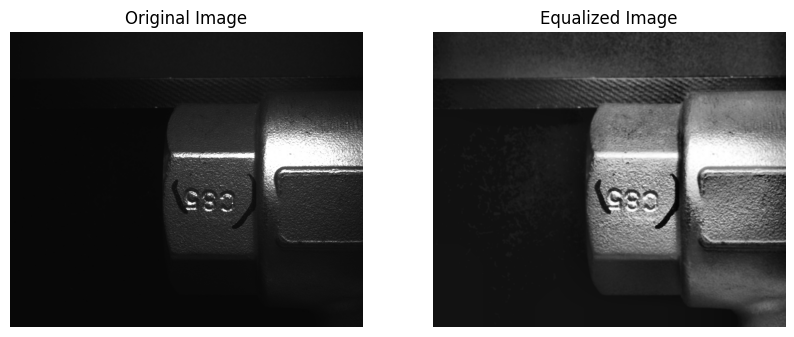

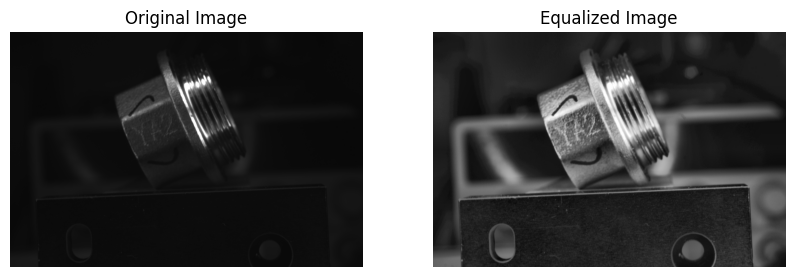

In [3]:
import os
import cv2
import sys
import matplotlib.pyplot as plt

def adjust_contrast_adaptive_histogram(image, clip_limit=2.0, tile_grid_size=(15, 15)):
    """
    使用自适应直方图均衡化调整图像的对比度。

    :param image: 输入图像
    :param clip_limit: 对比度限制参数 (2.0)
    :param tile_grid_size: 划分图像的网格大小
    :return: 调整后的图像
    """
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    adjusted_image = clahe.apply(image)
    return adjusted_image

srcpath = os.path.join(os.getcwd(), "data/imgs")
dstpath = os.path.join(srcpath, "CLAHE")
imgs = [file for file in os.listdir(srcpath) if file.find(".jpg") != -1]

for filename in imgs:
    # img = cv2.imread(os.path.join(srcpath, filename))
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # dst = cv2.equalizeHist(gray)
    # plt.imshow(dst)
    # plt.show()
    # sys.exit()
    image_path = os.path.join(srcpath, filename)
    original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load the image in grayscale


    equalized_image = adjust_contrast_adaptive_histogram(original_image, 9, (7, 7))

    equalized_image = cv2.bilateralFilter(equalized_image, 13, 75, 75)

    # Apply histogram equalization
    # equalized_image = cv2.equalizeHist(original_image)

    # Convert the original and equalized images to RGB for display
    original_rgb = cv2.cvtColor(original_image, cv2.COLOR_GRAY2RGB)
    equalized_rgb = cv2.cvtColor(equalized_image, cv2.COLOR_GRAY2RGB)
    
    # adjusted_image = cv2.convertScaleAbs(equalized_rgb, alpha=0.7, beta=0)
    if (filename.find("12.jpg") != -1):
        # Display the original and equalized images side by side
        plt.figure(figsize=(10, 4))

        plt.subplot(1, 2, 1)
        plt.title('Original Image')
        plt.imshow(original_rgb)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title('Equalized Image')
        plt.imshow(equalized_rgb)
        plt.axis('off')

        plt.show()
        
        # plt.imshow(adjusted_image)
        # plt.show()

    cv2.imwrite(os.path.join(dstpath, filename), equalized_rgb)
    # cv2.imwrite(os.path.join(dstpath, filename), equalized_rgb)
    # cv2.imwrite(os.path.join(os.path.join(dstpath, "constrast"), filename), adjusted_image)